# Setup

## 1. Clone dlfb library

In [ ]:
%cd /content
!rm -rf ./dlfb-clone/
!git clone "https://github.com/deep-learning-for-biology/dlfb.git" dlfb-clone --branch main
%cd dlfb-clone

/content
Cloning into 'dlfb-clone'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 121 (delta 19), reused 111 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 62.31 KiB | 3.67 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/dlfb-clone


## 2. Install Dependencies

In [ ]:
%%bash
curl -LsSf https://astral.sh/uv/install.sh | sh && \
export PATH="/root/.local/bin:${PATH}" && \
uv pip compile ./requirements/{base,dlfb,proteins,gpu}.txt \
  --color never \
  --constraint ./requirements/constraints.txt | \
uv pip install -r - --system

no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


downloading uv 0.9.16 x86_64-unknown-linux-gnu
Resolved 141 packages in 1.29s
Using Python 3.12.12 environment at: /usr
Resolved 141 packages in 1.39s
Prepared 1 package in 6.40s
Uninstalled 3 packages in 293ms
Installed 3 packages in 213ms
 ~ dlfb==0.1.1 (from file:///content/dlfb-clone)
 - numpy==2.3.5
 + numpy==2.1.2
 - scikit-learn==1.7.2
 + scikit-learn==1.4.2


## 3. Provide the datasets

In [ ]:
# NOTE: exclude models with '--no-models' flag
!dlfb-provision --chapter proteins

Files Downloaded: 100% 22/22 [00:01<00:00, 20.96file/s]


## 4. Import dlfb package

In [ ]:
# Toggle JAX_DISABLE_JIT to True for easier debugging
%env JAX_DISABLE_JIT=False

try:
  import dlfb
except ImportError as exc:
  # NOTE: Packages installed in editable mode are not immediately
  #       recognized by Colab (https://stackoverflow.com/a/63312333).
  import site
  site.main()
  import dlfb

from dlfb.utils.display import display

env: JAX_DISABLE_JIT=False


In [ ]:
!pip install --upgrade numpy scikit-learn

In [ ]:
from dlfb.utils.context import assets
import pandas as pd
import matplotlib.pyplot as plt


# Preparing the Data

## Loading the CAFA3 Data

There have been several rounds of CAFA, but the CAFA3 dataset is the most recent publicly available one. We first downloaded the `CAFA3 Targets` and `CAFA3 Training Data` files from the [CAFA website](https://biofunctionprediction.org/cafa/). Let’s start by loading the label file, which tells us the functional annotations for each protein:

In [ ]:
labels = pd.read_csv(
  assets("proteins/datasets/train_terms.tsv.zip"), sep="\t", compression="infer"
)
print(labels)

            EntryID        term aspect
0        A0A009IHW8  GO:0008152    BPO
1        A0A009IHW8  GO:0034655    BPO
2        A0A009IHW8  GO:0072523    BPO
3        A0A009IHW8  GO:0044270    BPO
4        A0A009IHW8  GO:0006753    BPO
...             ...         ...    ...
5363858      X5L565  GO:0050649    MFO
5363859      X5L565  GO:0016491    MFO
5363860      X5M5N0  GO:0005515    MFO
5363861      X5M5N0  GO:0005488    MFO
5363862      X5M5N0  GO:0003674    MFO

[5363863 rows x 3 columns]


- `EntryID`:
The UniProt ID of the protein

- `term`:
A GO accession code describing a specific protein function

- `aspect`:
The GO category the function belongs to; biological process (`BPO`), molecular function (`MFO`), and cellular component (`CCO`)

The `term` column contains only GO accession codes. To make these more interpretable, we’d ideally like to know their corresponding human-readable descriptions. This information isn’t included directly in the `CAFA` files, but it is available via the [Gene Ontology downloads page](https://geneontology.org/docs/download-ontology/). The ontology is stored in graph format as a `.obo` file, and we can use the `obonet` Python library to parse it. Here’s how we retrieve the term descriptions:



In [ ]:
import obonet
import os

def get_go_term_descriptions(store_path: str) -> pd.DataFrame:
  """Return GO term to description mapping, downloading if needed."""
  if not os.path.exists(store_path):
    url = "https://current.geneontology.org/ontology/go-basic.obo"
    graph = obonet.read_obo(url)

    # Extract GO term IDs and names from the graph nodes.
    id_to_name = {id: data.get("name") for id, data in graph.nodes(data=True)}
    go_term_descriptions = pd.DataFrame(
      zip(id_to_name.keys(), id_to_name.values()),
      columns=["term", "description"],
    )
    go_term_descriptions.to_csv(store_path, index=False)

  else:
    go_term_descriptions = pd.read_csv(store_path)
  return go_term_descriptions

In [ ]:
go_term_descriptions = get_go_term_descriptions(
  store_path=assets("proteins/datasets/go_term_descriptions.csv")
)
print(go_term_descriptions)

             term                                        description
0      GO:0000001                          mitochondrion inheritance
1      GO:0000002                   mitochondrial genome maintenance
2      GO:0000006  high-affinity zinc transmembrane transporter a...
3      GO:0000007  low-affinity zinc ion transmembrane transporte...
4      GO:0000009             alpha-1,6-mannosyltransferase activity
...           ...                                                ...
40209  GO:2001313  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...
40210  GO:2001314  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...
40211  GO:2001315  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...
40212  GO:2001316                       kojic acid metabolic process
40213  GO:2001317                    kojic acid biosynthetic process

[40214 rows x 2 columns]


We can then merge the human-readable term descriptions back onto the labels dataframe:

In [ ]:
labels = labels.merge(go_term_descriptions, on="term")
labels

,EntryID,term,aspect,description
0,A0A009IHW8,GO:0008152,BPO,metabolic process
1,A0A009IHW8,GO:0034655,BPO,nucleobase-containing compound catabolic process
2,A0A009IHW8,GO:0072523,BPO,purine-containing compound catabolic process
3,A0A009IHW8,GO:0006753,BPO,nucleoside phosphate metabolic process
4,A0A009IHW8,GO:1901292,BPO,nucleoside phosphate catabolic process
...,...,...,...,...
4933953,X5L565,GO:0050649,MFO,testosterone 6-beta-hydroxylase activity
4933954,X5L565,GO:0016491,MFO,oxidoreductase activity
4933955,X5M5N0,GO:0005515,MFO,protein binding
4933956,X5M5N0,GO:0005488,MFO,binding


we’ll focus specifically on molecular functions (`MFO`)—that is, what a protein does at the biochemical level.

In [ ]:
labels = labels[labels["aspect"] == "MFO"]
print(labels["description"].value_counts())

description
molecular_function                                78637
binding                                           57380
protein binding                                   47987
catalytic activity                                25324
heterocyclic compound binding                     12694
                                                  ...  
lovastatin nonaketide synthase activity               1
histone H3K37 methyltransferase activity              1
mitochondrion-plasma membrane adaptor activity        1
phenylacetate 2-hydroxylase activity                  1
NAD-dependent protein biotinidase activity            1
Name: count, Length: 6973, dtype: int64


We can already see that the distribution of function annotations is highly skewed. Some terms—like `molecular_function`, `binding`, and `protein binding`—appear tens of thousands of times, while others occur only once. Labels like `molecular_function` are arguably overly generic and provide little meaningful information, making them unhelpful for machine learning. We’ll filter these out in a later step.

A `FASTA` file is basically a text file containing many biological sequences.

```python
>ProteinID1234
MPLLLNVLAL...
>ProteinID5678
MKTSVAVL...
```

`SeqIO` is a `Biopython` module for reading and writing sequence files (`FASTA`, `GenBank`, etc.).

In [ ]:
from Bio import SeqIO

sequences_file = assets("proteins/datasets/train_sequences.fasta")
# returns: "/content/assets/proteins/datasets/train_sequences.fasta" in colab
fasta_sequences = SeqIO.parse(open(sequences_file), "fasta")

data = []
for fasta in fasta_sequences:
  data.append(
    {
      "EntryID": fasta.id,
      "Sequence": str(fasta.seq),
      "Length": len(fasta.seq),
    }
  )
sequence_df = pd.DataFrame(data)
print(sequence_df)

           EntryID                                           Sequence  Length
0           P20536  MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIP...     218
1           O73864  MTEYRNFLLLFITSLSVIYPCTGISWLGLTINGSSVGWNQTHHCKL...     354
2           O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...     258
3       A0A0B4J1F4  MGGEAGADGPRGRVKSLGLVFEDESKGCYSSGETVAGHVLLEAAEP...     415
4           P54366  MVETNSPPAGYTLKRSPSDLGEQQQPPRQISRSPGNTAAYHLTTAM...     415
...            ...                                                ...     ...
142241  A0A286YAI0  METEVDDFPGKASIFSQVNPLYSNNMKLCEAERYDFQHSEPKTMKS...     450
142242  A0A1D5NUC4  MSAAASAEMIETPPVLNFEEIDYKEIEVEEVVGRGAFGVVCKAKWR...     643
142243      Q5RGB0  MADKGPILTSVIIFYLSIGAAIFQILEEPNLNSAVDDYKNKTNNLL...     448
142244  A0A2R8QMZ5  MGRKKIQITRIMDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALI...     459
142245  A0A8I6GHU0  HCISSLKLTAFFKRSFLLSPEKHLVLLRDGRTLIGFLRSIDQFANL...     138

[142246 rows x 3 columns]


One important detail: the CAFA dataset includes proteins from many different organisms. To isolate human proteins, we’ll use the associated taxonomy file provided in the download:

In [ ]:
taxonomy_file = assets("proteins/datasets/train_taxonomy.tsv.zip")
taxonomy = pd.read_csv(taxonomy_file, sep="\t", compression="infer")
print(taxonomy)

           EntryID  taxonomyID
0           Q8IXT2        9606
1           Q04418      559292
2           A8DYA3        7227
3           Q9UUI3      284812
4           Q57ZS4      185431
...            ...         ...
142241      Q5TD07        9606
142242      A8BB17        7955
142243  A0A2R8QBB1        7955
142244      P0CT72      284812
142245      Q9NZ43        9606

[142246 rows x 2 columns]


This file contains a taxonomy ID (`taxonomyID`) for each protein, based on NCBI’s organism classification system. We’ll merge this onto our sequence dataframe and keep only proteins with `taxonomyID == 9606`, which corresponds to Homo sapiens:

In [ ]:
sequence_df = sequence_df.merge(taxonomy, on="EntryID")
sequence_df = sequence_df[sequence_df["taxonomyID"] == 9606]

In [ ]:
sequence_df = sequence_df.merge(labels, on="EntryID")
print(
  f'Dataset contains {sequence_df["EntryID"].nunique()} human proteins '
  f'with {sequence_df["term"].nunique()} molecular functions.'
)

Dataset contains 16336 human proteins with 4101 molecular functions.


In [ ]:
sequence_df

,EntryID,Sequence,Length,taxonomyID,term,aspect,description
0,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,258,9606,GO:0003676,MFO,nucleic acid binding
1,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,258,9606,GO:1990837,MFO,sequence-specific double-stranded DNA binding
2,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,258,9606,GO:0001216,MFO,DNA-binding transcription activator activity
3,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,258,9606,GO:0005488,MFO,binding
4,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...,258,9606,GO:0001228,MFO,"DNA-binding transcription activator activity, ..."
...,...,...,...,...,...,...,...
152521,Q549H9,MMEVESSYSDFISCDRTGRRNAVPDIQGDSEAVSVRKLAGDMGELA...,76,9606,GO:0005488,MFO,binding
152522,Q549H9,MMEVESSYSDFISCDRTGRRNAVPDIQGDSEAVSVRKLAGDMGELA...,76,9606,GO:0003674,MFO,molecular_function
152523,Q86TI6,MGAAAVRWHLCVLLALGTRGRLAGGSGLPGSVDVDECSEGTDDCHI...,347,9606,GO:0005515,MFO,protein binding
152524,Q86TI6,MGAAAVRWHLCVLLALGTRGRLAGGSGLPGSVDVDECSEGTDDCHI...,347,9606,GO:0005488,MFO,binding


From this table, we can already see that many proteins are associated with multiple molecular functions.

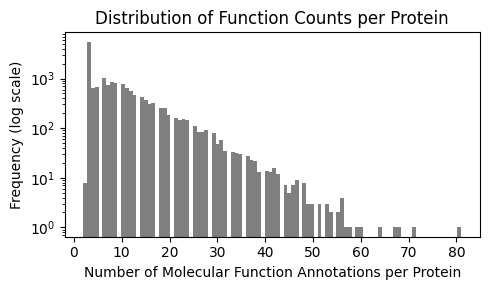

In [ ]:
sequence_df.groupby("EntryID")["term"].nunique().plot.hist(
  bins=100, figsize=(5, 3), color="grey", log=True
)
plt.xlabel("Number of Molecular Function Annotations per Protein")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Function Counts per Protein")
plt.tight_layout()

This pattern reflects a complex biological reality: while many proteins carry out a single, well-defined function, others are involved in a wide variety of molecular roles. For example, some proteins act as enzymes, bind to other molecules, and participate in multiple pathways. From a machine learning perspective, this means our model must be able to assign multiple function labels to a single protein and also cope with the fact that some labels are much rarer than others.

Some terms are so broad and universally assigned that they offer little meaningful insight. For example, `molecular function` applies to nearly all proteins, `binding` covers 93%, and `protein binding` appears in 89% of cases. These labels will tend to dominate the loss during training and can cause the model to fixate on predicting them at the expense of more meaningful functions. As a dataset preprocessing step, we’ll explicitly remove these overly generic terms:

In [ ]:
uninteresting_functions = [
  "GO:0003674",  # "molecular function". Applies to 100% of proteins.
  "GO:0005488",  # "binding". Applies to 93% of proteins.
  "GO:0005515",  # "protein binding". Applies to 89% of proteins.
]

sequence_df = sequence_df[~sequence_df["term"].isin(uninteresting_functions)]
sequence_df.shape

(106501, 7)

On the opposite end of the spectrum, some molecular functions are extremely rare—for example, `GO:0099609` (microtubule lateral binding) appears only once. To learn meaningful associations, our model needs enough training examples per function. So we’ll filter out the rarest labels and keep only those that appear in at least 50 proteins:

In [ ]:
common_functions = (
  sequence_df["term"]
  .value_counts()[sequence_df["term"].value_counts() >= 50]
  .index
)

sequence_df = sequence_df[sequence_df["term"].isin(common_functions)]
print(sequence_df.shape)
sequence_df["term"].value_counts()

(84288, 7)


,count
term,
GO:0003824,3875
GO:1901363,2943
GO:0003676,2469
GO:0042802,1803
GO:0016740,1652
...,...
GO:0005230,52
GO:0031490,51
GO:0005516,51


In [ ]:
sequence_df = (
  sequence_df[["EntryID", "Sequence", "Length", "term"]]
  .assign(value=1)
  .pivot(
    index=["EntryID", "Sequence", "Length"], columns="term", values="value"
  )
  .fillna(0) #Proteins that don’t have a GO term should have 0 in that column.
  .astype(int)
  .reset_index()
)
print(sequence_df)

term      EntryID                                           Sequence  Length  \
0      A0A024R6B2  MIASCLCYLLLPATRLFRALSDAFFTCRKNVLLANSSSPQVEGDFA...     670   
1      A0A087WUI6  MSRKISKESKKVNISSSLESEDISLETTVPTDDISSSEEREGKVRI...     698   
2      A0A087X1C5  MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...     515   
3      A0A0C4DG62  MAHVGSRKRSRSRSRSRGRGSEKRKKKSRKDTSRNCSASTSQERSK...     218   
4      A0A0C4DGF1  MSLPPIRLPSPYGSDRLVQLAARLRPALCDTLITVGSQEFPAHSLV...     302   
...           ...                                                ...     ...   
10704      Q9Y6Y8  MAERKPNGGSGGASTSSSGTNLLFSSSATEFSFNVPFIPVTQASAS...    1000   
10705      Q9Y6Y9  MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...     160   
10706      Q9Y6Z7  MNGFASLLRRNQFILLVLFLLQIQSLGLDIDSRPTAEVCATHTISP...     277   
10707      X5D778  MPKGGCPKAPQQEELPLSSDMVEKQTGKKDKDKVSLTKTPKLERGD...     421   
10708      X5D7E3  MLDLTSRGQVGTSRRMAEAACSAHFLETTPTPNPPTTEEEKTESNQ...     237   

term   GO:0000166  GO:0000287  GO:00009

At this point, we have a final dataset linking 10,709 human proteins to one or more of 303 molecular functions.

Since our simple mean embedding approach can be quite memory intensive, we’ll filter the dataset to include only proteins with a maximum length of 500 amino acids. This helps avoid out-of-memory errors during model inference and training:

In [ ]:
print(sequence_df.shape)
sequence_df = sequence_df[sequence_df["Length"] <= 500]
print(sequence_df.shape)

(10709, 306)
(5957, 306)


This roughly halves the dataset, which is perfectly fine for initial prototyping.

## Splitting the Dataset into Subsets

In [ ]:
from sklearn.model_selection import train_test_split

# 60% of the proteins will go into the training set.
train_sequence_ids, valid_test_sequence_ids = train_test_split(
  list(set(sequence_df["EntryID"])), test_size=0.40, random_state=42
)

# Split the remaining 40% evenly between validation and test sets.
valid_sequence_ids, test_sequence_ids = train_test_split(
  valid_test_sequence_ids, test_size=0.50, random_state=42
)

In [ ]:
sequence_splits = {
  "train": sequence_df[sequence_df["EntryID"].isin(train_sequence_ids)],
  "valid": sequence_df[sequence_df["EntryID"].isin(valid_sequence_ids)],
  "test": sequence_df[sequence_df["EntryID"].isin(test_sequence_ids)],
}

for split, df in sequence_splits.items():
  print(f"{split} has {len(df)} entries.")

train has 3574 entries.
valid has 1191 entries.
test has 1192 entries.


This gives us clean, nonoverlapping training, validation, and test sets—each containing a subset of proteins we’ll use throughout model development and evaluation.



## Converting Protein Sequences into Their Mean Embeddings

To make this process more convenient, we’ll use a pair of helper functions to store and load sequence embeddings:



In [ ]:
import torch
import numpy as np

def get_mean_embeddings(
  sequences: list[str],
  tokenizer,
  model,
  device: torch.device | None = None,
) -> np.ndarray:
  """Compute mean embedding for each sequence using a protein LM."""
  if not device:
    device = get_device()

  # Tokenize input sequences and pad them to equal length.
  model_inputs = tokenizer(sequences, padding=True, return_tensors="pt") # {"input_ids": tensor([]), "attention_mask": tensor([])}

  # Move tokenized inputs to the target device (CPU or GPU).
  model_inputs = {k: v.to(device) for k, v in model_inputs.items()}

  # Move model to the target device and set it to evaluation mode.
  model = model.to(device)
  model.eval()

  # Forward pass without gradient tracking to obtain embeddings.
  with torch.no_grad():
    outputs = model(**model_inputs)
    mean_embeddings = outputs.last_hidden_state.mean(dim=1)

  return mean_embeddings.detach().cpu().numpy()

In [ ]:
def store_sequence_embeddings(
  sequence_df: pd.DataFrame,
  store_prefix: str,
  tokenizer,
  model,
  batch_size: int = 64,
  force: bool = False,
) -> None:
  """Extract and store mean embeddings for each protein sequence."""
  model_name = str(model.name_or_path).replace("/", "_")
  store_file = f"{store_prefix}_{model_name}.feather"

  if not os.path.exists(store_file) or force:
    device = get_device()

    # Iterate through protein dataframe in batches, extracting embeddings.
    n_batches = ceil(sequence_df.shape[0] / batch_size)
    batches: list[np.ndarray] = []
    for i in range(n_batches):
      batch_seqs = list(
        sequence_df["Sequence"][i * batch_size : (i + 1) * batch_size]
      )
      batches.extend(get_mean_embeddings(batch_seqs, tokenizer, model, device))

    # Store each of the embedding values in a separate column in the dataframe.
    embeddings = pd.DataFrame(np.vstack(batches))
    embeddings.columns = [f"ME:{int(i)+1}" for i in range(embeddings.shape[1])]
    df = pd.concat([sequence_df.reset_index(drop=True), embeddings], axis=1)
    df.to_feather(store_file)


def load_sequence_embeddings(
  store_file_prefix: str, model_checkpoint: str
) -> pd.DataFrame:
  """Load stored embedding DataFrame from disk."""
  model_name = model_checkpoint.replace("/", "_")
  store_file = f"{store_file_prefix}_{model_name}.feather"
  return pd.read_feather(store_file)

In [ ]:
from transformers import AutoTokenizer, EsmModel

model_checkpoint = "facebook/esm2_t30_150M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = EsmModel.from_pretrained(model_checkpoint)

# for split, df in sequence_splits.items():
#   store_sequence_embeddings(
#     sequence_df=df,
#     store_prefix=assets(f"proteins/datasets/protein_dataset_{split}"),
#     tokenizer=tokenizer,
#     model=model,
#   )

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_df = load_sequence_embeddings(
  assets("proteins/datasets/protein_dataset_train"),
  model_checkpoint=model_checkpoint,
)

print(train_df)

         EntryID                                           Sequence  Length  \
0     A0A0C4DG62  MAHVGSRKRSRSRSRSRGRGSEKRKKKSRKDTSRNCSASTSQERSK...     218   
1     A0A1B0GTB2   MVITSENDEDRGGQEKESKEESVLAMLGIIGTILNLIVIIFVYIYTTL      48   
2         A0AVI4  MDSPEVTFTLAYLVFAVCFVFTPNEFHAAGLTVQNLLSGWLGSEDA...     362   
3         A0PJW6  MAAPWRRWPTGLLAVLRPLLTCRPLQGTTLQRDVLLFEHDRGRFFT...     202   
4         A1L167  MKELQDIARLSDRFISVELVDESLFDWNVKLHQVDKDSVLWQDMKE...     161   
...          ...                                                ...     ...   
3569      Q9Y6N5  MVPLVAVVSGPRAQLFACLLRLGTQQVGPLQLHTGASHAARNHYEV...     450   
3570      Q9Y6P5  MRLAAAANEAYTAPLAVSGLLGCKQCGGGRDQDEELGIRIPRPLGQ...     492   
3571      Q9Y6W5  MPLVTRNIEPRHLCRQTLPSVRSELECVTNITLANVIRQLGSLSKY...     498   
3572      Q9Y6W6  MPPSPLDDRVVVALSRPVRPQDLNLCLDSSYLGSANPGSNSHPPVI...     482   
3573      Q9Y6Y9  MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...     160   

      GO:0000166  GO:0000287  GO:0000976  GO:000097

Let’s now use our convert_to_tfds function to build a TensorFlow-compatible dataset from the DataFrame

In [ ]:
import tensorflow as tf

def convert_to_tfds(
  df: pd.DataFrame,
  embeddings_prefix: str = "ME:",
  target_prefix: str = "GO:",
  is_training: bool = False,
  shuffle_buffer: int = 50,
) -> tf.data.Dataset:
  """Convert embedding DataFrame into a TensorFlow dataset."""
  dataset = tf.data.Dataset.from_tensor_slices(
    {
      "embedding": df.filter(regex=f"^{embeddings_prefix}").to_numpy(),
      "target": df.filter(regex=f"^{target_prefix}").to_numpy(),
    }
  )
  if is_training:
    dataset = dataset.shuffle(shuffle_buffer).repeat()
  return dataset

In [ ]:
train_ds = convert_to_tfds(train_df, is_training=True)

Fetching a batch of data from these datasets is straightforward. We just batch the dataset, convert it to a NumPy iterator, and retrieve a batch by calling `next`:

In [ ]:
batch_size = 32

batch = next(train_ds.batch(batch_size).as_numpy_iterator())
batch["embedding"].shape, batch["target"].shape

((32, 640), (32, 303))

To streamline the dataset setup, we’ve wrapped the entire pipeline into a single helper function, build_dataset:

In [ ]:
def build_dataset(
  store_file_prefix: str, model_checkpoint: str
) -> dict[str, tf.data.Dataset]:
  """Build train/valid/test TensorFlow datasets from stored embeddings."""
  dataset_splits = {}

  for split in ["train", "valid", "test"]:
    dataset_splits[split] = convert_to_tfds(
      df=load_sequence_embeddings(
        store_file_prefix=f"{store_file_prefix}_{split}",
        model_checkpoint=model_checkpoint,
      ),
      is_training=(split == "train"),
    )
  return dataset_splits

This function loads the saved mean embeddings from disk for all three splits and constructs `tf.data.Dataset` objects that are ready for training:

In [ ]:
dataset_splits = build_dataset(
  assets("proteins/datasets/protein_dataset"), model_checkpoint=model_checkpoint
)

In [ ]:
dataset_splits

{'train': <_RepeatDataset element_spec={'embedding': TensorSpec(shape=(640,), dtype=tf.float32, name=None), 'target': TensorSpec(shape=(303,), dtype=tf.int64, name=None)}>,
 'valid': <_TensorSliceDataset element_spec={'embedding': TensorSpec(shape=(640,), dtype=tf.float32, name=None), 'target': TensorSpec(shape=(303,), dtype=tf.int64, name=None)}>,
 'test': <_TensorSliceDataset element_spec={'embedding': TensorSpec(shape=(640,), dtype=tf.float32, name=None), 'target': TensorSpec(shape=(303,), dtype=tf.int64, name=None)}>}

# Training the model

In this setup, we'll train a lightweight MLP (multilayer perceptron)

In [ ]:
import jax
import flax.linen as nn
from flax.training.train_state import TrainState


class Model(nn.Module):
  """Simple MLP for protein function prediction."""

  num_targets: int
  dim: int = 256

  @nn.compact
  def __call__(self, x):
    """Apply MLP layers to input features."""
    x = nn.Sequential(
      [
        nn.Dense(self.dim * 2),
        jax.nn.gelu,
        nn.Dense(self.dim),
        jax.nn.gelu,
        nn.Dense(self.num_targets),
      ]
    )(x)
    return x

  def create_train_state(self, rng: jax.Array, dummy_input, tx) -> TrainState:
    """Initialize model parameters and return a training state."""
    variables = self.init(rng, dummy_input)
    return TrainState.create(
      apply_fn=self.apply, params=variables["params"], tx=tx
    )

Reminder:

The `TrainState` object holds everything needed for model updates:

`params`: The current model parameters.

`tx`: The optimizer.

`apply_fn`:  The function that runs the model's forward pass.

**dummy input for shape inference**

In [ ]:
targets = list(train_df.columns[train_df.columns.str.contains("GO:")])

mlp = Model(num_targets=len(targets))

## Defining the Training Loop

Single `train_step`

- A forward pass through the model
- Computing the loss
- Calculating gradients
- Updating the model parameters using those gradients

In [ ]:
import optax

@jax.jit
def train_step(state, batch):
  """Run a single training step and update model parameters."""

  def calculate_loss(params):
    """Compute sigmoid cross-entropy loss from logits."""
    logits = state.apply_fn({"params": params}, x=batch["embedding"])
    loss = optax.sigmoid_binary_cross_entropy(logits, batch["target"]).mean()
    return loss

  grad_fn = jax.value_and_grad(calculate_loss, has_aux=False)
  loss, grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state, loss

We use a `sigmoid` activation and binary cross-entropy loss, appropriate for multilabel classification.

Reminder: `@jax.jit` compiles the training step for **better performance**.

`Eval_step`

some metrics to evaluate how well the model is doing beyond the loss alone

In [ ]:
from sklearn import metrics

def compute_metrics(
  targets: np.ndarray, probs: np.ndarray, thresh=0.5
) -> dict[str, float]:
  """Compute accuracy, recall, precision, auPRC, and auROC."""
  if np.sum(targets) == 0:
    return {
      m: 0.0 for m in ["accuracy", "recall", "precision", "auprc", "auroc"]
    }
  return {
    "accuracy": metrics.accuracy_score(targets, probs >= thresh),
    "recall": metrics.recall_score(targets, probs >= thresh),
    "precision": metrics.precision_score(
      targets,
      probs >= thresh,
      zero_division=0.0,
    ),
    "auprc": metrics.average_precision_score(targets, probs),
    "auroc": metrics.roc_auc_score(targets, probs),
  }

In a multilabel setting, we calculate these metrics for each protein function (i.e., `per target`/`label`), then average them to get a holistic view of model performance.

In [ ]:
def eval_step(state, batch) -> dict[str, float]:
  """Run evaluation step and return mean metrics over targets."""
  logits = state.apply_fn({"params": state.params}, x=batch["embedding"])
  loss = optax.sigmoid_binary_cross_entropy(logits, batch["target"]).mean()
  target_metrics = calculate_per_target_metrics(logits, batch["target"])
  metrics = {
    "loss": loss.item(),
    **pd.DataFrame(target_metrics).mean(axis=0).to_dict(),
  }
  return metrics


def calculate_per_target_metrics(logits, targets):
  """Compute metrics for each target in a multi-label batch."""
  probs = jax.nn.sigmoid(logits)
  target_metrics = []
  for target, prob in zip(targets, probs):
    target_metrics.append(compute_metrics(target, prob))
  return target_metrics

This tells us how well the model predicts sets of functions per protein. It does not report performance per GO term. If we wanted `per-function` metrics (e.g., how well the model predicts GO:0003677), we'd need to compute metrics column-wise instead.

In [ ]:
def train(
  state: TrainState,
  dataset_splits: dict[str, tf.data.Dataset],
  batch_size: int,
  num_steps: int = 300,
  eval_every: int = 30,
):
  """Train model using batched TF datasets and track performance metrics."""
  # Create containers to handle calculated during training and evaluation.
  train_metrics, valid_metrics = [], []

  # Create batched dataset to pluck batches from for each step.
  train_batches = (
    dataset_splits["train"]
    .batch(batch_size, drop_remainder=True)
    .as_numpy_iterator()
  )

  steps = tqdm(range(num_steps))  # Steps with progress bar.
  for step in steps:
    steps.set_description(f"Step {step + 1}")

    # Get batch of training data, convert into a JAX array, and train.
    state, loss = train_step(state, next(train_batches))
    train_metrics.append({"step": step, "loss": loss.item()})

    if step % eval_every == 0:
      # For all the evaluation batches, calculate metrics.
      eval_metrics = []
      for eval_batch in (
        dataset_splits["valid"].batch(batch_size=batch_size).as_numpy_iterator()
      ):
        eval_metrics.append(eval_step(state, eval_batch))
      valid_metrics.append(
        {"step": step, **pd.DataFrame(eval_metrics).mean(axis=0).to_dict()}
      )

  return state, {"train": train_metrics, "valid": valid_metrics}

A few notes on this training loop:

Efficient batch sampling:

Training data is streamed via `.as_numpy_iterator()`, and the `.`repeat() in the dataset ensures infinite looping over the data.

Metric aggregation:

Validation metrics are computed batch-wise and then averaged across all batches using `pd.DataFrame(...).mean(axis=0)`. This gives a stable estimate of performance across the entire validation set.

to avoid unnecessarily repeating training from scratch every time you rerun your code cell, we use the `@restorable` decorator. This lightweight utility checks whether a trained model already exists at a specified path. If it does, it:

- Skips retraining
- Restores the model into a valid TrainState
- Returns the model along with any saved metrics

This makes your workflow much faster and more reproducible, especially during iterative development and debugging.

In [ ]:
import optax

from dlfb.utils.restore import restorable

# Initiate training state with dummy data from a single batch.
rng = jax.random.PRNGKey(42)
rng, rng_init = jax.random.split(key=rng, num=2)

state, metrics_ = restorable(train)(
  state=mlp.create_train_state(
    rng=rng_init, dummy_input=batch["embedding"], tx=optax.adam(0.001)
  ),
  dataset_splits=dataset_splits,
  batch_size=32,
  num_steps=300,
  eval_every=30,
  store_path=assets("proteins/models/mlp"),
)

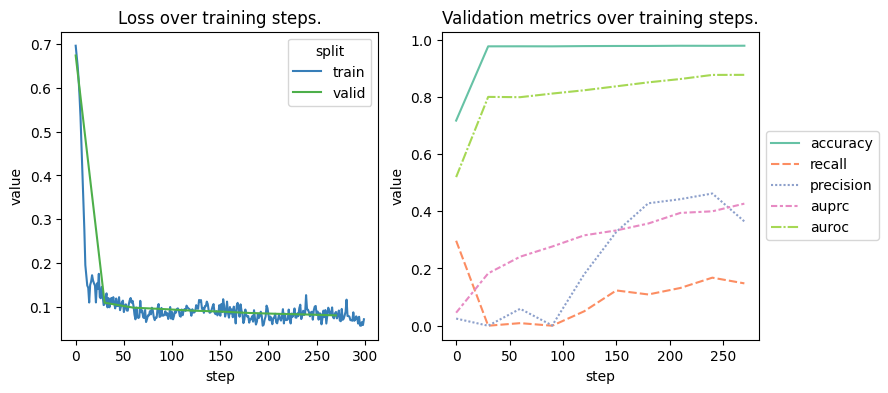

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from dlfb.utils.metric_plots import DEFAULT_SPLIT_COLORS

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# Plot training loss curve.
learning_data = pd.concat(
  pd.DataFrame(metrics_[split]).melt("step").assign(split=split)
  for split in ["train", "valid"]
)

sns.lineplot(
  ax=ax[0],
  x="step",
  y="value",
  hue="split",
  data=learning_data[learning_data["variable"] == "loss"],
  palette=DEFAULT_SPLIT_COLORS,
)
ax[0].set_title("Loss over training steps.")

# Plot validation metrics curves.
sns.lineplot(
  ax=ax[1],
  x="step",
  y="value",
  hue="variable",
  style="variable",
  data=learning_data[learning_data["variable"] != "loss"],
  palette="Set2",
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].set_title("Validation metrics over training steps.");

- Accuracy and auROC start high and remain flat, but these can be misleading in imbalanced, multilabel settings like this one. Since most function labels are negative (i.e., a protein lacks the majority of all possible functions), a model that mostly predicts zeros can still achieve a high score on these metrics. For that reason, we don’t put much weight on these metrics in this context.

- auPRC steadily improves and does not fully plateau, suggesting the model continues to learn subtle distinctions and could potentially benefit from further training (i.e., by increasing num_steps).

- Precision improves more quickly than recall, indicating the model becomes increasingly confident in its predictions but still fails to capture some true positives.

## Examining the model predictions

With a trained model in hand, it’s time to explore its strengths and weaknesses. We’ll start by generating predictions for the entire validation set and storing them in a dataframe for easier inspection

In [ ]:
valid_df = load_sequence_embeddings(
  store_file_prefix=f"{assets('proteins/datasets/protein_dataset')}_valid",
  model_checkpoint=model_checkpoint,
)

# Use batch size of 1 to avoid dropping the remainder.
valid_probs = []
for valid_batch in dataset_splits["valid"].batch(1).as_numpy_iterator():
  logits = state.apply_fn({"params": state.params}, x=valid_batch["embedding"])
  valid_probs.extend(jax.nn.sigmoid(logits))

valid_true_df = valid_df[["EntryID"] + targets].set_index("EntryID")
valid_prob_df = pd.DataFrame(
  np.stack(valid_probs), columns=targets, index=valid_true_df.index
)

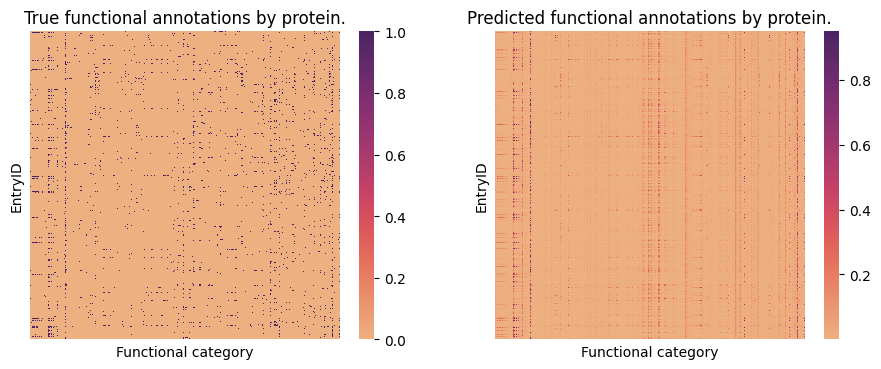

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))

sns.heatmap(
  ax=ax[0],
  data=valid_true_df,
  yticklabels=False,
  xticklabels=False,
  cmap="flare",
)
ax[0].set_title("True functional annotations by protein.")
ax[0].set_xlabel("Functional category")

sns.heatmap(
  ax=ax[1],
  data=valid_prob_df,
  yticklabels=False,
  xticklabels=False,
  cmap="flare",
)
ax[1].set_title("Predicted functional annotations by protein.")
ax[1].set_xlabel("Functional category");

- Some protein functions appear frequently in the dataset (visible as vertical stripes), and the model tends to predict these relatively well.
- Rare functions are harder to capture—the model often misses them entirely, leading to sparse or empty columns in the predicted heatmap.
- A few functions are over-predicted, visible as faint vertical lines across many proteins, suggesting the model is overly confident for those categories.
- Many cells in the predicted matrix show intermediate color tones, which reflect more uncertain probabilities (not a confident near-0 or near-1).

We’ll now shift from this qualitative view to a quantitative one by evaluating model performance on each protein function (`per function`) individually

In [ ]:
metrics_by_function = {}
for function in targets:
  metrics_by_function[function] = compute_metrics(
    valid_true_df[function].values, valid_prob_df[function].values
  )

overview_valid = (
  pd.DataFrame(metrics_by_function)
  .T.merge(go_term_descriptions, left_index=True, right_on="term")
  .set_index("term")
  .sort_values("auprc", ascending=False)
)
print(overview_valid)

            accuracy    recall  precision     auprc     auroc  \
term                                                            
GO:0004930  0.958858  0.000000   0.000000  0.948591  0.982272   
GO:0004888  0.945424  0.177215   1.000000  0.849885  0.968354   
GO:0003824  0.848027  0.731591   0.819149  0.849362  0.909372   
GO:1990837  0.954660  0.543689   0.888889  0.825313  0.970820   
GO:0043565  0.955500  0.649123   0.850575  0.821888  0.963243   
...              ...       ...        ...       ...       ...   
GO:0004714  0.999160  0.000000   0.000000  0.001094  0.232773   
GO:0042626  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:0051015  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:0003774  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:1902936  0.000000  0.000000   0.000000  0.000000  0.000000   

                                                  description  
term                                                           
GO:0004930                

This analysis reveals substantial variation in model performance across protein functions. For instance, the model performs well on functions like GO:0004930 (G protein–coupled receptor activity), but it struggles with others, such as GO:0003774 (cytoskeletal motor activity). However, interpreting these results requires caution: some metrics may be based on very few validation examples, and performance is naturally limited for functions that are underrepresented during training. A high score on a frequent function may simply reflect ample training data, while low scores on rare functions may be expected.

Our evaluation metrics fall into two categories: thresholded and continuous.

- Precision and recall are computed from binary predictions—i.e., after applying a fixed threshold (typically >0.5) to the model’s output probabilities.

- auPRC (area under the precision–recall curve) and auROC (area under the receiver operating characteristic curve) are threshold independent. They assess how well the model ranks positive examples above negatives across all possible thresholds.

Although a bit counterintuitive, it’s entirely possible for precision and recall to be 0 while auPRC and auROC remain high. This happens when the model assigns higher probabilities to the correct labels, but those probabilities never exceed the decision threshold. In such cases, thresholded metrics show failure, while ranking-based metrics still reflect meaningful signal.

If we wanted to address this issue with the current thresholded metrics, we could lower the decision threshold—for example, to 0.2 or 0.3—to encourage more positive predictions. The threshold can be tuned automatically using metrics like the F1 score (the harmonic mean of precision and recall).

Let’s take a closer look at whether there’s a relationship between how often a protein function appears in the training data and how well the model learns to predict it in the validation set:

In [ ]:
# Compute number of occurrences of each function in the training set.
overview_valid = overview_valid.merge(
  pd.DataFrame(train_df[targets].sum(), columns=["train_n"]),
  left_index=True,
  right_index=True,
)
print(overview_valid)

            accuracy    recall  precision     auprc     auroc  \
GO:0004930  0.958858  0.000000   0.000000  0.948591  0.982272   
GO:0004888  0.945424  0.177215   1.000000  0.849885  0.968354   
GO:0003824  0.848027  0.731591   0.819149  0.849362  0.909372   
GO:1990837  0.954660  0.543689   0.888889  0.825313  0.970820   
GO:0043565  0.955500  0.649123   0.850575  0.821888  0.963243   
...              ...       ...        ...       ...       ...   
GO:0004714  0.999160  0.000000   0.000000  0.001094  0.232773   
GO:0042626  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:0051015  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:0003774  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:1902936  0.000000  0.000000   0.000000  0.000000  0.000000   

                                                  description  train_n  
GO:0004930                G protein-coupled receptor activity      138  
GO:0004888          transmembrane signaling receptor activity      228  


At a glance, it seems that functions with higher predictive performance (e.g., higher auPRC) also tend to have more training examples.

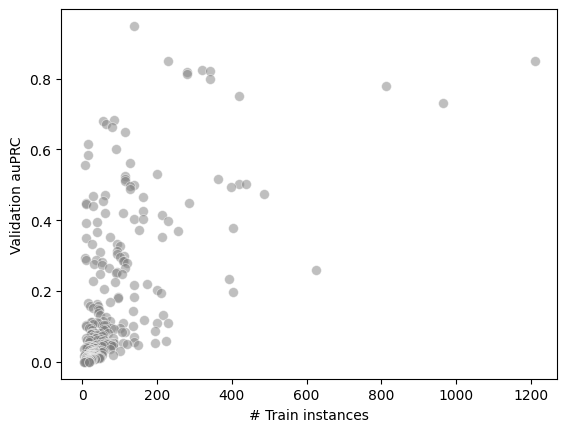

In [ ]:
fig = sns.scatterplot(
  x="train_n", y="auprc", data=overview_valid, alpha=0.5, s=50, color="grey"
)
fig.set_xlabel("# Train instances")
fig.set_ylabel("Validation auPRC");

But how do we know whether a specific auPRC score is actually good? An auPRC value of, say, 0.8 for a certain protein function might sound promising—but is that better than chance? Is it meaningful? To interpret these scores, we need something to compare them against.

- Coin flip

For each protein function, randomly predict 0 or 1 with equal probability. This gives us a baseline for total ignorance.

- Proportional guessing

Predict 1 for each function with probability equal to its frequency in the training set. This reflects prior class distribution knowledge, but without any learning.

In [ ]:
valid_true_df

,GO:0000166,GO:0000287,GO:0000976,GO:0000977,GO:0000978,GO:0000981,GO:0000987,GO:0001067,GO:0001216,GO:0001217,...,GO:0140677,GO:0140678,GO:1901265,GO:1901363,GO:1901681,GO:1901702,GO:1901981,GO:1902936,GO:1990782,GO:1990837
EntryID,,,,,,,,,,,,,,,,,,,,,
A1A4Y4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
A5LHX3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A5PLL7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A6NHX0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A6NJ46,0,0,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6J6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Q9Y6K0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q9Y6K9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Fianl Check on the Test Set

In [ ]:
eval_metrics = []

for split in ["valid", "test"]:
  split_metrics = []

  for eval_batch in dataset_splits[split].batch(32).as_numpy_iterator():
    split_metrics.append(eval_step(state, eval_batch))

  eval_metrics.append(
    {"split": split, **pd.DataFrame(split_metrics).mean(axis=0).to_dict()}
  )
print(pd.DataFrame(eval_metrics))

   split      loss  accuracy    recall  precision     auprc     auroc
0  valid  0.080156  0.978457  0.126869   0.418515  0.411870  0.880883
1   test  0.080675  0.978032  0.125820   0.435193  0.410439  0.879234
